<a href="https://colab.research.google.com/github/Smart-Construction-FUM/Datathon2021-FUM/blob/main/Datapex_datathon2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_data_dir = "/content/drive/MyDrive/processed_data/train"
test_data_dir = "/content/drive/MyDrive/processed_data/test"
valid_data_dir = "/content/drive/MyDrive/processed_data/val"

In [4]:
IMG_HEIGHT, IMG_WIDTH = (224, 224)
BATCH_SIZE = 32

In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")


test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode="categorical")


EPOCHS = 20

base_model = ResNet50(include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"])




history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=EPOCHS)

Found 797 images belonging to 5 classes.
Found 311 images belonging to 5 classes.
Found 247 images belonging to 5 classes.
Epoch 1/20
25/25 [==============================] - 214s 9s/step - loss: 0.9652 - acc: 0.7516 - val_loss: 0.3378 - val_acc: 0.8875
Epoch 2/20
25/25 [==============================] - 174s 7s/step - loss: 0.2052 - acc: 0.9360 - val_loss: 0.1925 - val_acc: 0.9550
Epoch 3/20
25/25 [==============================] - 175s 7s/step - loss: 0.1549 - acc: 0.9385 - val_loss: 0.2942 - val_acc: 0.9132
Epoch 4/20
25/25 [==============================] - 177s 7s/step - loss: 0.1214 - acc: 0.9598 - val_loss: 0.2755 - val_acc: 0.9293
Epoch 5/20
25/25 [==============================] - 174s 7s/step - loss: 0.1013 - acc: 0.9699 - val_loss: 0.2373 - val_acc: 0.9518
Epoch 6/20
25/25 [==============================] - 177s 7s/step - loss: 0.1082 - acc: 0.9661 - val_loss: 0.3852 - val_acc: 0.9068
Epoch 7/20
25/25 [==============================] - 174s 7s/step - loss: 0.1113 - acc: 0.96

In [9]:
model.save("/content/drive/MyDrive/processed_data/saved_model/ResNet50_Debris.h5")

In [10]:
test_loss,test_acc = model.evaluate(test_generator,verbose=2)
print('\nTest Accuracy:',test_acc)

247/247 - 87s - loss: 0.3662 - acc: 0.9190 - 87s/epoch - 350ms/step

Test Accuracy: 0.9190283417701721


In [11]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/processed_data/saved_model/ResNet50_Debris.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()


In [12]:
for _ in range(nb_samples):
  X_test, Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

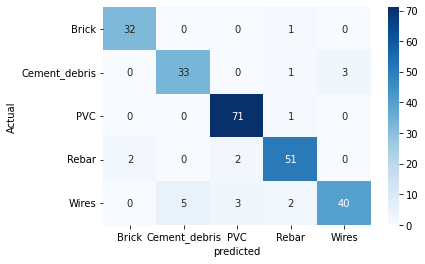

test accuracy: 91.90283400809717


In [13]:
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['predicted'])
sn.heatmap(confusion_matrix,cmap = 'Blues',annot = True, fmt = 'd')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))